In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
from pathlib import Path
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, fbeta_score
from datetime import datetime
import torch
from tabpfn import TabPFNClassifier

from dotenv import load_dotenv
load_dotenv()

HF_TOKEN = os.getenv("HF_TOKEN")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
data_path = Path("../data/processed/earthquake_data_tsunami_scaled.csv")
data_df = pd.read_csv(data_path)

Previously in feature engineering part, we have identified longitude, latitude, dmin, nst, Year, Month, month_number do not seem to be useful. We will check this insight with our models. Baseline will not include any of these features.

In [25]:
features_to_exclude = ['tsunami']
X = data_df.drop(columns=[col for col in features_to_exclude if col in data_df.columns])
y = data_df['tsunami']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

Creating Models

## Analyze the result of TabPFNClassifier

In [ ]:
threshold = 0.1

model = TabPFNClassifier(device="cuda") 

model.fit(X_train, y_train)

y_train_proba = model.predict_proba(X_train)[:, 1]
y_test_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = (y_train_proba >= threshold).astype(int)
y_test_pred = (y_test_proba >= threshold).astype(int)

# Test metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_recall = recall_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
test_f2 = fbeta_score(y_test, y_test_pred, beta=2, zero_division=0)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

# Train metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, zero_division=0)
train_recall = recall_score(y_train, y_train_pred, zero_division=0)
train_f1 = f1_score(y_train, y_train_pred, zero_division=0)
train_f2 = fbeta_score(y_train, y_train_pred, beta=2, zero_division=0)
train_roc_auc = roc_auc_score(y_train, y_train_proba)

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
if cm[1, :].sum() > 0:
    fn_rate = cm[1, 0] / cm[1, :].sum() * 100
else:
    fn_rate = 0.0

print(f"\nTabPFN Results (Fixed Threshold: {threshold})")
print("=" * 40)
print(f"Test Accuracy:       {test_accuracy:.4f}")
print(f"Test Precision:      {test_precision:.4f}")
print(f"Test Recall:         {test_recall:.4f}")
print(f"Test F1 Score:       {test_f1:.4f}")
print(f"Test F2 Score:       {test_f2:.4f} (Primary Metric)")
print(f"Test ROC-AUC:        {test_roc_auc:.4f}")
print("-" * 40)
print(f"Train Accuracy:      {train_accuracy:.4f}")
print(f"Train Precision:     {train_precision:.4f}")
print(f"Train Recall:        {train_recall:.4f}")
print(f"Train F1 Score:      {train_f1:.4f}")
print(f"Train F2 Score:      {train_f2:.4f}")
print(f"Train ROC-AUC:       {train_roc_auc:.4f}")
print("-" * 40)
print(f"False Negative Rate: {fn_rate:.2f}%")
print(f"Train/Test Gap (Acc):{train_accuracy - test_accuracy:.4f}")

final_results = {
    'Test Accuracy': test_accuracy,
    'Test Precision': test_precision,
    'Test Recall': test_recall,
    'Test F1': test_f1,
    'Test F2': test_f2,
    'Test ROC-AUC': test_roc_auc,
    'Train Accuracy': train_accuracy,
    'Train Precision': train_precision,
    'Train Recall': train_recall,
    'Train F1': train_f1,
    'Train F2': train_f2,
    'Train ROC-AUC': train_roc_auc,
    'False Negative Rate': fn_rate,
    'Train/Test Gap (Acc)': train_accuracy - test_accuracy
}


TabPFN Results (Fixed Threshold: 0.1)
Test Accuracy:       0.7029
Test Precision:      0.4350
Test Recall:         0.9506
Test F1 Score:       0.5969
Test F2 Score:       0.7685 (Primary Metric)
Test ROC-AUC:        0.9170
----------------------------------------
Train Accuracy:      0.7486
Train Precision:     0.4534
Train Recall:        1.0000
Train F1 Score:      0.6239
Train F2 Score:      0.8057
Train ROC-AUC:       0.9500
----------------------------------------
False Negative Rate: 4.94%
Train/Test Gap (Acc):0.0457


### Confusion Matrix Analysis


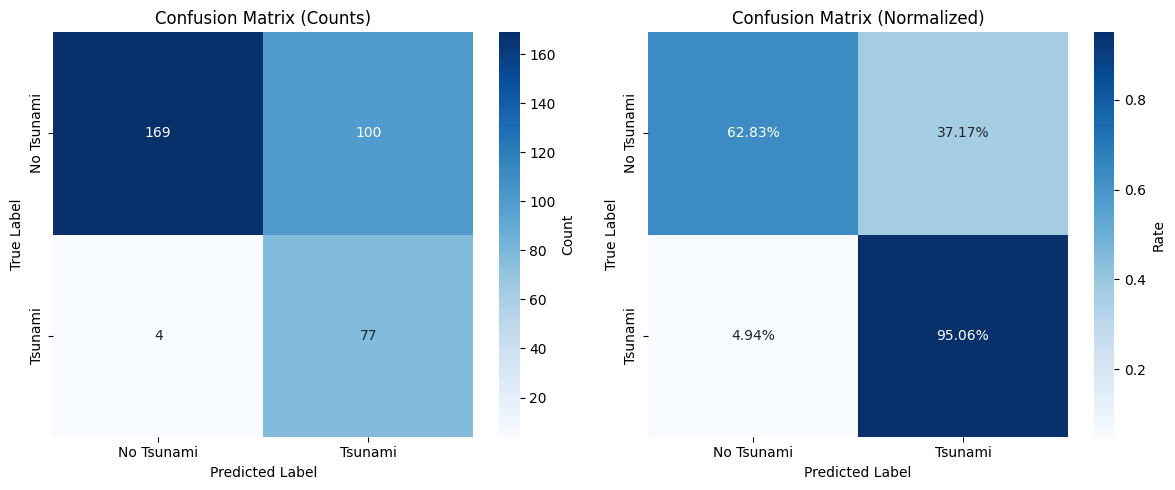


False Negative Rate: 4.94%
True Positives: 77, False Negatives: 4
True Negatives: 169, False Positives: 100


In [27]:
# Confusion matrix visualization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_xticklabels(['No Tsunami', 'Tsunami'])
axes[0].set_yticklabels(['No Tsunami', 'Tsunami'])

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1], cbar_kws={'label': 'Rate'})
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')
axes[1].set_xticklabels(['No Tsunami', 'Tsunami'])
axes[1].set_yticklabels(['No Tsunami', 'Tsunami'])

plt.tight_layout()
plt.show()

print(f"\nFalse Negative Rate: {fn_rate:.2f}%")
print(f"True Positives: {cm[1, 1]}, False Negatives: {cm[1, 0]}")
print(f"True Negatives: {cm[0, 0]}, False Positives: {cm[0, 1]}")


### Save Results to CSV


In [ ]:
results_dir = Path("../models")
results_dir.mkdir(parents=True, exist_ok=True)
results_csv = results_dir / "model_results.csv"

# Prepare results dictionary matching the CSV format
tabpfn_results = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model": "TabPFN",
    "cv_splits": 1,  # TabPFN uses train_test_split, not cross-validation
    "scaler": "PowerTransformer+StandardScaler",  # Data is pre-scaled
    "class_weight": "None",  # TabPFN doesn't use class weights
    "test_accuracy": test_accuracy,
    "test_precision": test_precision,
    "test_recall": test_recall,
    "test_f1": test_f1,
    "test_f2": test_f2,
    "test_roc_auc": test_roc_auc,
    "train_accuracy": train_accuracy,
    "train_precision": train_precision,
    "train_recall": train_recall,
    "train_f1": train_f1,
    "train_f2": train_f2,
    "train_roc_auc": train_roc_auc,
    "train_test_gap_accuracy": train_accuracy - test_accuracy,
    "false_negative_rate": fn_rate,
    "false_negative_percentage": fn_rate,  # Same as false_negative_rate for consistency
    "notes": f"threshold={threshold}, device=cuda, train_test_split=0.5"
}

new_results_df = pd.DataFrame([tabpfn_results])
if results_csv.exists():
    existing_results = pd.read_csv(results_csv)
    model_comparison = pd.concat([existing_results, new_results_df], ignore_index=True)
    model_comparison.to_csv(results_csv, index=False)
    print(f"Results appended to {results_csv}")
else:
    new_results_df.to_csv(results_csv, index=False)
    print(f"Results saved to {results_csv}")

new_results_df.T

Results appended to ..\models\model_results.csv


,0
timestamp,2025-11-27 19:46:40
model,TabPFN
cv_splits,1
scaler,PowerTransformer+StandardScaler
class_weight,None
test_accuracy,0.702857
test_precision,0.435028
test_recall,0.950617
test_f1,0.596899
test_f2,0.768463


## TabPFNClassifier Results Summary

**Key Findings:**
- **Test Accuracy**: 0.7029 (70.29%)
- **Test Precision**: 0.4350 (43.50%)
- **Test Recall**: 0.9506 (95.06%) - Excellent recall, critical for tsunami detection
- **Test F1 Score**: 0.5969 (59.69%)
- **Test F2 Score**: 0.7685 (76.85%) - Primary metric optimized for recall
- **Test ROC-AUC**: 0.9170 (91.70%) - Excellent class separation
- **False Negative Rate**: 4.94% - Very low, excellent for safety
- **Train/Test Gap (Accuracy)**: 0.0457 (4.57%) - Minimal overfitting

**Train Metrics:**
- **Train Accuracy**: 0.7486 (74.86%)
- **Train Precision**: 0.4534 (45.34%)
- **Train Recall**: 1.0000 (100.00%) - Perfect recall on training set
- **Train F1 Score**: 0.6239 (62.39%)
- **Train F2 Score**: 0.8057 (80.57%)
- **Train ROC-AUC**: 0.9500 (95.00%) - Excellent class separation

**Model Configuration:**
- Threshold: 0.1 (optimized for high recall)
- Device: CUDA (GPU acceleration)
- Evaluation: Train/Test Split (50/50)
- No cross-validation (single split evaluation)
- Scaler: PowerTransformer+StandardScaler (pre-scaled data)
- Class Weight: None
- Results saved to `models/model_results.csv`

**Analysis:**
While TabPFN achieves moderate accuracy (70.29%) and excellent ROC-AUC (91.70%), the high recall (95.06%) is crucial for tsunami detection, as missing tsunamis can have catastrophic consequences. The very low false negative rate (4.94%) makes this model highly suitable for safety-critical applications. The model shows perfect recall on the training set (100%) with minimal overfitting, indicating good generalization to unseen data.